In [145]:
import gym
import torch
from torch import nn
import numpy as np
from collections import OrderedDict
from tqdm.notebook import tqdm
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [2]:
environment = gym.make('CartPole-v1')

In [3]:
state = environment.reset()

In [4]:
state

array([-0.01189994,  0.02158726,  0.03750295,  0.00165666], dtype=float32)

In [5]:
environment.action_space

Discrete(2)

In [6]:
environment.step(0)

(array([-0.0114682 , -0.17405191,  0.03753608,  0.30593234], dtype=float32),
 1.0,
 False,
 {})

## Network

In [7]:
class Network(nn.Module):
    def __init__(self, N_state, N_hidden, N_output):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(N_state, N_hidden),
            nn.ReLU(),
            nn.Linear(N_hidden, N_hidden),
            nn.ReLU(),
            nn.Linear(N_hidden, N_output),
            nn.Softmax()
        )
        
        
    def forward(self, x):
        x = self.net(x)
        return x

In [40]:
net = Network(4, 16, 2)

In [41]:
net(torch.from_numpy(state))

/Users/stephanrasp/mambaforge/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0.5044, 0.4956], grad_fn=<SoftmaxBackward0>)

In [138]:
# write fn to flatten and unflatten parameters and convert to np
def vec_from_state_dict(state_dict):
    shapes = []
    vec = np.array([])
    for k, v in state_dict.items():
        a = v.numpy().flatten()
        vec = np.append(vec, a)
    return vec

In [139]:
def state_dict_from_vec(vec, state_dict):
    dic = OrderedDict()
    count = 0
    for k, v in state_dict.items():
        shape = v.numpy().shape
        size = v.numpy().flatten().shape[0]
        n = vec[count:count+size].reshape(shape)
        dic[k] = torch.from_numpy(n)
        count+=size
    return dic

## Training

In [180]:
class EnKI():
    def __init__(self, env, net_class, net_params, N_ens, obs_noise=1e-1, iterations_per_step=10):
        self.env = env
        self.N_ens = N_ens
        self.nets = [net_class(**net_params) for _ in range(N_ens)]
        self.R = np.diag(np.ones(1) * obs_noise)
        self.param_hist = []
        self.reward_hist = []
        self.iterations_per_step = iterations_per_step
        
    def train(self, episodes):
        pbar = tqdm(range(episodes))
        for _ in pbar:
            rewards = self.episode()
            self.reward_hist.append(rewards)
            self.update(rewards)
            pbar.set_postfix({'Avg. reward':  rewards.mean()})
        
    def episode(self):
        rewards = []
        for i in range(self.N_ens):
            reward = self.episode_per_member(i)
            rewards.append(reward)
        return np.array(rewards)
            
    def episode_per_member(self, i):
        total_reward = 0
        for i in range(self.iterations_per_step):
            obs = self.env.reset()
            while True:
                action = self.act(i, obs)
                obs, reward, done, info = env.step(action)
                total_reward += reward
                if done:
                    break
        return total_reward / self.iterations_per_step
    
    def act(self, i, obs):
        probs = self.nets[i](torch.from_numpy(obs)).detach().numpy()
        action = np.random.choice([0, 1], p=probs)
        return action
    
    def update(self, rewards):
        x_f_ens = np.array([vec_from_state_dict(n.state_dict()) for n in self.nets]).T   # n x N_ens 
        
        hx_f_ens = -rewards[None, :]  # m x N_ens
        
        X = x_f_ens - x_f_ens.mean(1)[:, None]
        Y = hx_f_ens - hx_f_ens.mean(1)[:, None]
        K = X @ Y.T @ inv(Y @ Y.T + (self.N_ens - 1) * self.R)
        
        x_a_ens = x_f_ens - K
        
        for i, n in enumerate(self.nets):
            s = state_dict_from_vec(x_a_ens[:, i], n.state_dict())
            n.load_state_dict(s)
            
        self.param_hist.append(x_a_ens)
        
        

In [181]:
env = gym.make('CartPole-v1')

In [182]:
enki = EnKI(env, Network, {'N_state': 4, 'N_hidden': 16, 'N_output': 2}, N_ens=100, iterations_per_step=100)

In [189]:
enki.train(20)

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/stephanrasp/mambaforge/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [190]:
np.array(enki.param_hist).shape

(45, 386, 100)

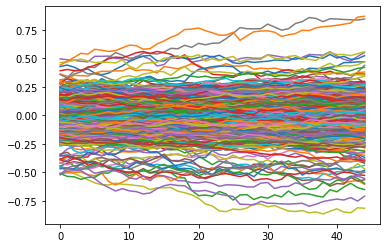

In [191]:
plt.plot(np.array(enki.param_hist)[:, :, 0]);

In [192]:
obs

array([-0.0380681 , -0.02046182, -0.00837889, -0.03349997], dtype=float32)

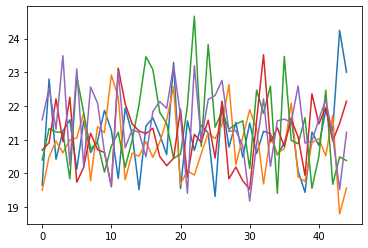

In [193]:
plt.plot(np.array(enki.reward_hist)[:, :5]);

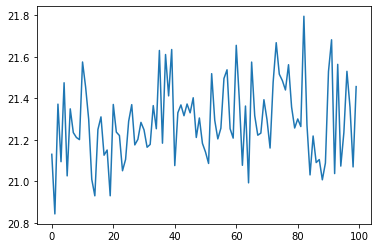

In [194]:
plt.plot(np.array(enki.reward_hist).mean(0))